# Semantic interpretation.

Semantic interpretation is a NLP technique to draw the meaning of a text/sentence. In this implementation, we will focuse on determining two sentences in different languages (english and spanish) have the same meaning.

Some possible sentences for our dataset are:

- Woman buys new car & Mujer compra coche nuevo (1)
- Man buys blue car & Mujer compra coche azul (0)
- Woman buys new car & Mujer compra automóvil nuevo (1)
- Man buys new car & Hombre compra automóvil viejo (0)
- Woman buys old car & Mujer adquiere coche viejo (1)
- Woman buys new car & Mujer hurta coche nuevo (0)
- Woman buys new car & Mujer roba coche rojo (0)
- Woman steals red car & Mujer roba coche rojo (0)
...

Where each example follows this structure: Sentence in english & Sentence in spanish (meaning coincidence label).

Our dataset is built using this vocabulary:


| Subject | Verbs | Objects | Adjectives | | Nombres | Verbos | Objetos | Adjetivos |
| --- | --- | --- | --- | | --- | --- | --- | --- |
| Woman | steals | car | old | | Mujer | roba | coche | viejo |
| Man | buys | sofa | new | | Hombre | hurta | automóvil | nuevo |
|  | purchases | coach | red | |  | compra | sillón | rojo |
|  | breaks | notebook | blue | |  | rompe | cuaderno | azul |


The proposed vocabulary has 14 words and two different kind of sentences for each language:
- Subject + Verb + Object (32 sentences)
- Subject + Verb + (Adj +) Object (128 sentences)

This makes 160 sentences per language and hence 25600 possible combinations.

## 1. Create dataset

### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have three types of words: nouns, adjectives, verbs (transitive). We also distinguish two different types of nouns: objects and subjects. 

In [1]:
import numpy as np
import pickle

In [3]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns (subjects)
man, woman = Word('man', n), Word('woman', n)
mujer, hombre = Word('mujer', n), Word('hombre', n)
# nouns (objects)
car, sofa, coach, notebook = Word('car', n), Word('sofa', n), Word('coach', n), Word('notebook', n)
coche, automovil, sillon, cuaderno = Word('coche', n), Word('automovil', n), Word('sillón', n), Word('cuaderno', n)
# adjectives
old, new, red, blue = Word('old', n @ n.l), Word('new', n @ n.l), Word('red', n @ n.l), Word('blue', n @ n.l) 
viejo, nuevo, rojo, azul = Word('viejo', n.r @ n), Word('nuevo', n.r @ n ), Word('rojo', n.r @ n ), Word('blue', n.r @ n )
# Transitive verbs
buys, purchases, steals, breaks  = Word('buys', n.r @ s @ n.l), Word('purchases', n.r @ s @ n.l), Word('steals', n.r @ s @ n.l), Word('breaks', n.r @ s @ n.l)
compra, roba, hurta, rompe  = Word('compra', n.r @ s @ n.l), Word('roba', n.r @ s @ n.l), Word('hurta', n.r @ s @ n.l), Word('rompe', n.r @ s @ n.l)

subjects = [man, woman]
sujetos = [mujer, hombre]
verbs = [buys, purchases, steals, breaks]
verbos = [compra, roba, hurta, rompe]
adjectives = [old, new, red, blue]
adjetivos = [viejo, nuevo, rojo, azul]
objects = [car, sofa, coach, notebook]
objetos = [coche,  sillon, automovil, cuaderno]


vocab_E = subjects + verbs + adjectives + objects 
vocab_S = sujetos + verbos + adjetivos + objetos

### 1.2. Define the grammar

In this dataset we are going to consider the following structures to construct the sentences:

- noun + t. verb + noun



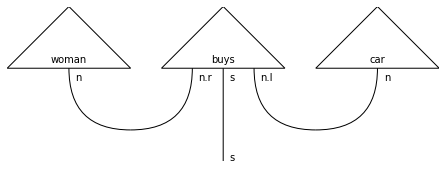

In [5]:
from discopy import Cup, Id, pregroup

grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ buys @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + adjective + noun (for english)

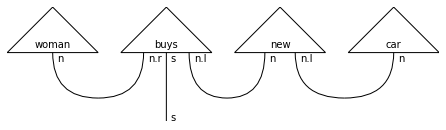

In [6]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n)
sentence = woman @ buys @ new @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + noun +adjective (for spanish)

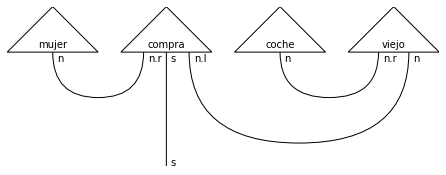

In [7]:
grammar =  Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)
sentence = mujer @ compra @ coche @ viejo >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [8]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'NVN' :  Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'NVAN' : Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n),
    'NVNA' : Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)}                                                                   

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# English noun+verb+noun sentences
parsing_NVNe = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in subjects for verb in verbs for obj in objects}
sentences_NVNe = list(parsing_NVNe.keys())
for sentence in sentences_NVNe:
    diagram = parsing_NVNe[sentence]
    data_psr[sentence] = parsing_NVNe[sentence]
    
# Spanish noun+verb+noun sentences
parsing_NVNs = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in sujetos for verb in verbos for obj in objetos}
sentences_NVNs = list(parsing_NVNs.keys())
for sentence in sentences_NVNs:
    diagram = parsing_NVNs[sentence]
    data_psr[sentence] = parsing_NVNs[sentence]
    
# English noun+verb+adjective+noun sentences
parsing_NVANe = {"{} {} {} {}.".format(subj, verb, adj, obj): subj @ verb @ adj @ obj  >> grammar_dict['NVAN']
            for subj in subjects  for verb in verbs for adj in adjectives for obj in objects}
sentences_NVANe = list(parsing_NVANe.keys())
for sentence in sentences_NVANe:
    diagram = parsing_NVANe[sentence]
    data_psr[sentence] = parsing_NVANe[sentence]
    
# Spanish noun+verb+noun+adjectives sentences
parsing_NVNAs = {"{} {} {} {}.".format(subj, verb, obj, adj): subj @ verb @ obj @ adj  >> grammar_dict['NVNA']
            for subj in sujetos for verb in verbos for obj in objetos  for adj in adjetivos}
sentences_NVNAs = list(parsing_NVNAs.keys())
for sentence in sentences_NVNAs:
    diagram = parsing_NVNAs[sentence]
    data_psr[sentence] = parsing_NVNAs[sentence]

### 1.3. Process the data (Complete with data sets)

In [6]:
with open('.txt') as f:
    data = f.readlines()

In [ ]:
#Change when we have the data sets
labels_dict = {}
data_psr_dict = {}
sent_type = {}
for sentence in data:
    sentstr = sentence[:-7]
    if sentence[-6:-3] == 'int':
        diagram = parsing_int[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'int'
    elif sentence[-6:-3] == 'tra':
        diagram = parsing_tra[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'tra'

Now we have our dataset! The only problem left is the fact that the cups used in the diagrams are too resource consumming. Luckily, it is possible to remove them by transforming the states into effects (we are just doing this with the nouns as in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources). 

Let us apply this to our entire dataset.

In [12]:
#Change when we have the data sets
data_new_psr_dict = {}
for sentstr in data_psr_dict.keys():
    num_words = len(sentstr.split(' '))
    words = data_psr_dict[sentstr].boxes[:num_words]
    if sent_type[sentstr] == 'int':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2])
        sentence = words_new >> grammar_dict['ADJ_N_IV']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif sent_type[sentstr] == 'tra':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[2].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
        sentence = words_new >> grammar_dict['N_TV_N']
        data_new_psr_dict[sentstr] = sentence.normal_form()

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [13]:
from discopy import Cap, Box
#English
vocab_psr_E = []
for word in vocab_E:
    if word.cod == Ty('n'):
        vocab_psr_E.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr_E.append(word)
#Spanish
vocab_psr_S = []
for word in vocab_S:
    if word.cod == Ty('n'):
        vocab_psr_S.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr_S.append(word)
vocab_psr=vocab_psr_E+vocab_psr_S

## 2. Create quantum circuit

Once the dataset and its corresponding diagrams are created, the next step is to construct the variational quantum circuits associated with them. In order to do that, we will use different ansätze depending on the type of the word that we want to represent. In this case we only have three types of words, nouns, adjetives and verbs. Nouns will have associated 1 qubit, and sentences three qubits, therefore verbs 5 qubits, and adjetives 2 qubits. Moreover, we will also distinguish between states and effects when constructing the ansätze.

In [25]:
from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.circuit import Circuit
from functools import reduce, partial

q_s = 3 # number of qubits for type s (sentence)
q_n = 1 # number of qubits for type n (noun)
depth = 1 # depth of the IQPansatz

# Define the dimensions of the objects of the circuit functor
ob = {s: q_s, n: q_n}                          
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   

# Define the ansätze for states and effects
def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return IQPansatz(1, params)       

def ansatz_state(state, params):  
    arity = sum(ob[Ty(factor.name)] for factor in state.cod)
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    else:
        return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params):  
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    else:
        return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

# Construct the circuit functor
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})
    return Functor(ob_cqmap, ar)

In [26]:
#*****************************************************
# Functions to deal with the parametrisation
#*****************************************************

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i]))))
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

In [27]:
#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     40


In [ ]:
# Print the quantum circuit for each sentence

func = F(rand_shaped_pars)

for sentstr in data_new_psr_dict:
    print(sentstr)
    print(data_new_psr_dict[sentstr])
    func(data_new_psr_dict[sentstr]).draw(draw_box_labels=True, figsize=(5, 5))

## 3. Create training and test dataset

In [30]:
#Complete when we have data sets
training_data_eng = []      # list of sentences in english in the train dataset as strings "word1 word2 ..."
testing_data_eng = []       # list of sentences in english in the test dataset as strings "word1 word2 ..."
training_data_spa = []      # list of sentences in spanish in the train dataset as strings "word1 word2 ..."
testing_data_spa = []       # list of sentences in spanish in the test dataset as strings "word1 word2 ..."
train_labels=[]             # list of labels english-spanish sentances in the training dataset
test_labels=[]              # list of labels english-spanish sentances in the test dataset

In [19]:
# If we want to work with Qiskit circuits

from pytket.extensions.qiskit import tk_to_qiskit
from discopy.quantum.tk import to_tk

qiskit_train_circuits = []
for diagram in train_data_psr:
    circuit = func(diagram)
    pytket_circuit = circuit.to_tk()
    qiskit_train_circuits.append(tk_to_qiskit(pytket_circuit))
    
qiskit_test_circuits = []
for diagram in test_data_psr:
    circuit = func(diagram)
    pytket_circuit = circuit.to_tk()
    qiskit_test_circuits.append(tk_to_qiskit(pytket_circuit))

## 4. Optimization functions

The next step is to define the functions that we will use for the optimization. We will resort to a classical optimizer to perform this variational optimization, more concretely the SPSA. The cost function for this algorithm is the cross entropy, which is used to measure the distance between two probability distributions. For two probability distributions $S$ and $L$, the cross entropy $D$ is defined as

\begin{equation}
    D(S,L) = - \sum_i L_i \log (S_i).
\end{equation}

In our problem we have the labels that account for the ideal probability distribution $L$ associated to each pair of sentences, while the output of the variational algorithm is the distribution $S$.

Now we are going to define a function to compute the cross entropy for our problem, as well as the probabilities associated to each quantum circuit and the train and test errors.

In [20]:
from pytket.extensions.qiskit import AerBackend
from discopy.quantum import Measure
backend = AerBackend()
max_n_shots = 8192  # maximum shots possible

In [21]:
def get_probs(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    train_circuits_eng = [(func(circ) >> Measure() @ Measure()) for circ in train_data_psr_eng]
    train_circuits_spa = [(func(circ) >> Measure() @ Measure()) for circ in train_data_psr_spa]
    results_eng = Circuit.get_counts(*train_circuits_eng, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
    results_spa = Circuit.get_counts(*train_circuits_spa, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
    results_joined = [np.sum([math.sqrt(counts_eng)*math.sqrt(counts_spa) 
                             for (counts_eng,counts_spa) in zip(res_eng.values(),res_spa.values())]) 
                            for res_eng in results_eng for res_spa in results_spa]
    pred_labels_distrs = results_joined
    return pred_labels_distrs

def get_cost(pred_labels_distrs):
    cross_entropies = np.array([np.sum(train_labels[s] * np.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
    return -1 / len(train_data_psr) * np.sum(cross_entropies)

def get_train_error(pred_labels_distrs):
    correct = 0
    for (i, res) in enumerate(pred_labels_distrs):
        pred_result = round(res) #We are taken as 1 (same meaning) when the output is >0.5 and viceversa
        train_result = round(train_labels[i]) 
        if train_result == pred_result:
            correct += 1
    return 100 - correct * 100 / len(pred_labels_distrs)

def get_test_error(unshaped_params):
    test_circuits_eng = [(func(circ) >> Measure() @ Measure()) for circ in train_data_psr_eng]
    test_circuits_spa = [(func(circ) >> Measure() @ Measure()) for circ in train_data_psr_spa]
    results_eng = Circuit.get_counts(*test_circuits_eng, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
    results_spa = Circuit.get_counts(*test_circuits_spa, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
    results_joined = [np.sum([math.sqrt(counts_eng)*math.sqrt(counts_spa) 
                             for (counts_eng,counts_spa) in zip(res_eng.values(),res_spa.values())]) 
                            for res_eng in results_eng for res_spa in results_spa]
    correct = 0
    pred_labels = []
    for i, res in enumerate(results_joined):
        pred_result = round(res) #We are taken as 1 (same meaning) when the output is >0.5 and viceversa
        test_result = round(test_labels[i])
        pred_labels.append(pred_result)
        if test_result == pred_result:
            correct += 1
    return 100 - correct * 100 / len(results_joined), pred_labels

Once we have the cost function, we define a customized SPSA optimizer suitable for our task.

In [22]:
#**********************************************************************************
# Minimization algorithm
#**********************************************************************************

# This is building on the minimizeSPSA function from the noisyopt package (https://github.com/andim/noisyopt);
# here only adjusted for our purposes. As this is an example notebook for a final run of the experiment
# the dev set is not used here.

def my_spsa(get_probs, get_cost, get_train_error, get_test_error, x0,
            bounds=None, niter=100, shots=1024, a=1.0, c=1.0, alpha=0.602, gamma=0.101,
            print_iter=False, correct_func_value=True,
            filename='spsa_output', iters_selected=[]):
    A = 0.01 * niter
    N = len(x0)
    if bounds is None:
        project = lambda x: x
    else:
        bounds = np.asarray(bounds)
        project = lambda x: np.clip(x, bounds[:, 0], bounds[:, 1])    
    param_history = []
    func_history = []
    error_history = []
    pred_label_history = []
    pred_labels_test_error = dict()
    test_error_list = []
    x = x0    
    
    # Loop over iterations
    for k in range(niter):
        if print_iter:
            print('-------------', '\n', 'iteration: ', k, sep='')
        start = time()
        
        # determine stepping parameters
        ak = a/(k+1.0+A)**alpha
        ck = c/(k+1.0)**gamma
        delta = np.random.choice([-1, 1], size=N)
        
        # move in + direction from previous x
        xplus = project(x + ck*delta)        
        if print_iter:
            print('Call for xplus')
        results_tweaked_plus = get_probs(xplus)
        funcplus = get_cost(results_tweaked_plus)
        
        # move in - direction from previous x
        xminus = project(x - ck*delta)
        if print_iter:
            print('Call for xminus')
        results_tweaked_minus = get_probs(xminus)
        funcminus = get_cost(results_tweaked_minus)
        
        # new step
        grad = (funcplus - funcminus) / (xplus-xminus)
        x = project(x - ak*grad)
        param_history.append(x)
        
        # determine current func and error
        if correct_func_value or k == (niter - 1):  # In order to save time the cost at x is only evaluated for final step
            if print_iter:
                print('Call for current_func_value')
            results_tweaked = get_probs(x)
            current_func_value = get_cost(results_tweaked)
            error = get_train_error(results_tweaked)
            pred_label_history.append(results_tweaked)
        else:
            current_func_value = funcplus
            error = get_train_error(results_tweaked_plus)
            pred_label_history.append(results_tweaked_plus)
        
        # calculate test error if a 'selected iteration' 
        if k in iters_selected:
            print('Calculate test error for iteration:', k)
            res = get_test_error(x)
            test_error_list.append(res[0])
            pred_labels_test_error.update({k: res[1]})
        
        func_history.append(current_func_value)
        error_history.append(error)

        # save to file
        dump_data = {
            'param_history': param_history,
            'func_history': func_history,
            'error_history': error_history,
            'predlabel_history': pred_label_history,
            'iters_selected': iters_selected,
            'test_error_list': test_error_list,
            'pred_labels_test_error': pred_labels_test_error
        }
        with open(filename+'.pickle', 'wb') as file_handle:
            pickle.dump(dump_data, file_handle)
        
        if print_iter:
            print('Time taken for this iteration: ', time() - start)
    return param_history, func_history, error_history, test_error_list

Finally, we can run the optimizer and obtain the results.

In [ ]:
#************************************
# Quantum run: training and error calculation
#************************************
from time import time

bounds = [[0.0, 1.0] for ii in range(len(rand_unshaped_pars))]
c_fix = 0.1   
a_est = 0.015  

n_runs = 1
niter = 1000
param_histories = []
cost_histories = np.zeros((n_runs, niter))
error_train_histories = np.zeros((n_runs, niter))

# For test error calculation (for reasons of time cost not for all iterations)
iters_selected = [(i+1)*10-1 for i in range(int(niter/10))]
iters_selected.insert(0, 0)
error_test_histories = np.zeros((n_runs, len(iters_selected)))

for i in range(n_runs):
    print('---------------------------------')
    print('Start run ', i+1)
    rand_unshaped_pars = randparams(par_shapes)
    start = time()
    res = my_spsa(get_probs, get_cost, get_train_error, get_test_error, rand_unshaped_pars,
                  bounds=bounds, niter=niter, shots=1, a=a_est, c=c_fix,
                  print_iter=True, correct_func_value=False, filename=('MC_task_SPSAOutput_Run' + str(i)),
                  iters_selected=iters_selected)
    param_histories.append(res[0])   
    cost_histories[i, :] = res[1]
    error_train_histories[i, :] = res[2]
    error_test_histories[i, :] = res[3]
    print('run', i+1, 'done')
    print('Time taken: ', time() - start)

In [ ]:
#****************************************************
# Averaging
#****************************************************

# In case N_runs > 1, one may want to calculate cost and errors averaged over several runs...

# In this example notebook however not done, hence:
cost_history = cost_histories[0, :]
error_train_history = error_train_histories[0, :]
error_test_history = error_test_histories[0, :]

In [ ]:
#****************************************************
# Summary plot
#****************************************************
from matplotlib import pyplot as plt

plt.rcParams.update({"text.usetex": True})
fig, ax1 = plt.subplots(figsize=(13, 8))

ax1.plot(range(len(cost_history)), cost_history, '-k', markersize=4, label='cost')
ax1.set_ylabel(r"Cost", fontsize='x-large')
ax1.set_xlabel(r"SPSA~iterations", fontsize='x-large')
ax1.legend(loc='upper center', fontsize='x-large')

ax2 = ax1.twinx()
ax2.set_ylabel(r"Error in \%", fontsize='x-large')
ax2.plot(range(len(error_train_history)), error_train_history, '-g', markersize=4, label='training error')
ax2.plot(iters_selected, error_test_history, 'xb', markersize=7, label='testing error')
ax2.legend(loc='upper right', fontsize='x-large')

plt.title('MC task, quantum run -- results', fontsize='x-large')
plt.savefig('MC_task_Results.png', dpi=300, facecolor='white')  
plt.show()

In [ ]:
final_params = res[0][-1]
func = F(reshape_params(final_params, par_shapes))
final_train_circuits = [(func(circ) >> Measure() @ Measure()) for circ in train_data_psr]
final_test_circuits = [(func(circ) >> Measure() @ Measure()) for circ in test_data_psr]
train_results = Circuit.eval(*final_train_circuits, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
test_results = Circuit.eval(*final_test_circuits, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
train_results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in train_results]
test_results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in test_results]
pred_train_results = [res.flatten() / np.sum(res) for res in train_results_tweaked]
pred_test_results = [res.flatten() / np.sum(res) for res in test_results_tweaked]

In [ ]:
correct = 0
for i, res in enumerate(pred_train_results):
    pred_result = np.argmax(res.flatten())
    train_result = np.argmax(train_labels[i])
    print(train_sent[i])
    #print(res.flatten())
    print(pred_result,train_result)
    if train_result == pred_result:
        correct += 1
    #print(f'Result: {train_array, train_result}, Predicted result: {res, pred_result}')
print('Correct predictions (train):',correct/len(train_results_tweaked))

In [ ]:
correct = 0
for i, res in enumerate(test_results_tweaked):
    pred_result = np.argmax(res.flatten())
    test_result = np.argmax(test_labels[i])
    if test_result == pred_result:
        correct += 1
print('Correct predictions (test):',correct/len(test_results_tweaked))